In [2]:
import sys
sys.path.append("/home/vassm/entity_alignment/kg_entity_alignment_2024/notebooks/data_prep")

In [12]:
import os
import json
import torch
from sentence_transformers import util, SentenceTransformer
from loaders import graph_folder_path, gold_folder_path, load_gold

In [13]:
exactmatch_path = "/home/vassm/entity_alignment/kg_entity_alignment_2024/outputs/exact_match/label_altlabel"
exactmatch_deduplicated_path = "/home/vassm/entity_alignment/kg_entity_alignment_2024/outputs/exact_match_deduplicated"

dogtags_path = "/home/vassm/entity_alignment/kg_entity_alignment_2024/features/dogtags/version2"

top1000pairs_path = "/home/vassm/entity_alignment/kg_entity_alignment_2024/features/top1000pairs/bgelarge_v1"
top100pairs_path = "/home/vassm/entity_alignment/kg_entity_alignment_2024/features/top100pairs/bgelarge_v1"

embeddings_path = "/home/vassm/entity_alignment/kg_entity_alignment_2024/features/embeddings/version2"
embeddings_postfix = "_lab_altlab_type_abs_comment_BAAI_bge-large-en-v1.5.json"

In [48]:
def get_left_recall(loaded_gold, gold1, g1_name2id, g2_name2id, g2_embedding, forward_top, topk):
    fns = list()
    tps = list()

    for goldpair in loaded_gold:
        ith = list(gold1.keys()).index(str(g1_name2id[goldpair[0]]))
        ith2 = list(g2_embedding.keys()).index(str(g2_name2id[goldpair[1]]))

        found = False
        for element in forward_top[ith][:topk]:
            if str(element['corpus_id']) == str(ith2):
                tps.append(goldpair)
                found = True
                break
        if not found:
            fns.append(goldpair)
    recall = len(tps)/(len(tps) + len(fns))
    return recall, len(tps), len(fns)


def get_right_recall(loaded_gold, gold2, g1_name2id, g2_name2id, g1_embedding, backward_top, topk):
    fns = list()
    tps = list()

    for goldpair in loaded_gold:
        ith = list(gold2.keys()).index(str(g2_name2id[goldpair[1]]))
        ith2 = list(g1_embedding.keys()).index(str(g1_name2id[goldpair[0]]))

        found = False
        for element in backward_top[ith][:topk]:
            if str(element['corpus_id']) == str(ith2):
                tps.append(goldpair)
                found = True
                break
        if not found:
            fns.append(goldpair)
    recall = len(tps)/(len(tps) + len(fns))
    return recall, len(tps), len(fns)

In [62]:
golds = list(filter(lambda x: ".xml" in x, os.listdir(os.path.split(gold_folder_path)[0])))

data_container = list()
missing_d = dict()
topX = 50
topk = 1000
topXs = [10, 50, 100, 500, 1000]
for gold in golds:
    print(gold)
    loaded_gold = load_gold(gold)
    loaded_gold = loaded_gold[0]

    g1, g2 = gold.replace(".xml", "").split("-")

    if g1 == "marvelcinematicuniverse":
        g1 = "mcu"

    with open(os.path.join(embeddings_path, g1 + embeddings_postfix), "r") as f:
        g1_embedding = json.load(f)
    with open(os.path.join(embeddings_path, g2 + embeddings_postfix), "r") as f:
        g2_embedding = json.load(f)

    graph1_path = os.path.join(graph_folder_path, g1 + ".triples")
    with open(graph1_path.replace(".triples", "_mapping.json"), "r") as f:
        g1_name2id = json.load(f)
        g1_id2name = dict((v,k) for k,v in g1_name2id.items())

    graph2_path = os.path.join(graph_folder_path, g2 + ".triples")
    with open(graph2_path.replace(".triples", "_mapping.json"), "r") as f:
        g2_name2id = json.load(f)
        g2_id2name = dict((v,k) for k,v in g2_name2id.items())

    gold1 = dict()
    gold2 = dict()
    missing = list()
    for goldpair in loaded_gold:
        try:
            gold1[str(g1_name2id[goldpair[0]])] = g1_embedding[str(g1_name2id[goldpair[0]])]
        except Exception as e:
            missing.append([goldpair, "0"])

        try:
            gold2[str(g2_name2id[goldpair[1]])] = g2_embedding[str(g2_name2id[goldpair[1]])]
        except Exception as e:
            missing.append([goldpair, "1"])
    missing_d[gold] = missing
    g1_torch_golds = torch.Tensor(list(gold1.values()))
    g2_torch_golds = torch.Tensor(list(gold2.values()))
    g1_torch_embeds = torch.Tensor(list(g1_embedding.values()))
    g2_torch_embeds = torch.Tensor(list(g2_embedding.values()))
    forward_top = util.semantic_search(g1_torch_golds, g2_torch_embeds, top_k=topk)
    backward_top = util.semantic_search(g2_torch_golds, g1_torch_embeds, top_k=topk)

    for tx in topXs:

        left_recall, left_tps, left_fns = get_left_recall(loaded_gold, gold1, g1_name2id, g2_name2id, g2_embedding, forward_top, tx)
        right_recall, right_tps, right_fns = get_right_recall(loaded_gold, gold2, g1_name2id, g2_name2id, g1_embedding, backward_top, tx)
        data_container.append([g1+"-"+g2, "left", tx, left_recall, left_tps, left_fns])
        data_container.append([g1+"-"+g2, "right", tx, right_recall, right_tps, right_fns])

marvelcinematicuniverse-marvel.xml
memoryalpha-memorybeta.xml
memoryalpha-stexpanded.xml
starwars-swg.xml
starwars-swtor.xml


In [59]:
import pandas as pd

recall_df = pd.DataFrame(data_container, columns=["dataset", "direction", "topx", "recall", "tp", "fn"])
recall_df

,dataset,direction,topx,recall,tp,fn
0,mcu-marvel,left,10,0.578884,965,702
1,mcu-marvel,right,10,0.719856,1200,467
2,mcu-marvel,left,50,0.734853,1225,442
3,mcu-marvel,right,50,0.818236,1364,303
4,mcu-marvel,left,100,0.780444,1301,366
5,mcu-marvel,right,100,0.856629,1428,239
6,mcu-marvel,left,500,0.865027,1442,225
7,mcu-marvel,right,500,0.925615,1543,124
8,mcu-marvel,left,1000,0.893221,1489,178
9,mcu-marvel,right,1000,0.939412,1566,101


In [61]:
recall_df.to_json("/home/vassm/entity_alignment/kg_entity_alignment_2024/stats/gold_recall/gold_recall_per_topx.json", orient="records")

In [67]:
import json
with open("/home/vassm/entity_alignment/kg_entity_alignment_2024/stats/gold_recall/gold_recall_per_topx_missing.json", "w") as f:
    json.dump(missing_d, f)

In [68]:
recall_df = pd.read_json("/home/vassm/entity_alignment/kg_entity_alignment_2024/stats/gold_recall/gold_recall_per_topx.json")

In [69]:
grouped_data = recall_df.groupby(['dataset', "direction"])['recall'].apply(list)
grouped_data2 = recall_df.groupby(['dataset', "direction"]).agg({'recall':lambda x: list(x),
                                                                 'topx':lambda x: list(x)})

In [70]:
grouped_data

dataset                 direction
mcu-marvel              left         [0.5788842232, 0.7348530294000001, 0.780443911...
                        right        [0.7198560288, 0.8182363527000001, 0.856628674...
memoryalpha-memorybeta  left         [0.8213561132, 0.8666310731, 0.883182060900000...
                        right        [0.8219967966, 0.8636412173, 0.8835024026, 0.9...
memoryalpha-stexpanded  left         [0.9162450815000001, 0.957841484, 0.9713322091...
                        right        [0.9123102867, 0.9477234401, 0.9606520517, 0.9...
starwars-swg            left         [0.9339875112, 0.9634255129, 0.9723461195, 0.9...
                        right        [0.8947368421, 0.9250669045000001, 0.934879571...
starwars-swtor          left         [0.9601119664000001, 0.9846046186, 0.988103568...
                        right        [0.9538138558, 0.9692092372000001, 0.974107767...
Name: recall, dtype: object

In [71]:
grouped_data2

recall  \
dataset                direction                                                      
mcu-marvel             left       [0.5788842232, 0.7348530294000001, 0.780443911...   
                       right      [0.7198560288, 0.8182363527000001, 0.856628674...   
memoryalpha-memorybeta left       [0.8213561132, 0.8666310731, 0.883182060900000...   
                       right      [0.8219967966, 0.8636412173, 0.8835024026, 0.9...   
memoryalpha-stexpanded left       [0.9162450815000001, 0.957841484, 0.9713322091...   
                       right      [0.9123102867, 0.9477234401, 0.9606520517, 0.9...   
starwars-swg           left       [0.9339875112, 0.9634255129, 0.9723461195, 0.9...   
                       right      [0.8947368421, 0.9250669045000001, 0.934879571...   
starwars-swtor         left       [0.9601119664000001, 0.9846046186, 0.988103568...   
                       right      [0.9538138558, 0.9692092372000001, 0.974107767...   

                                                      topx  
dataset                direction                            
mcu-marvel             left       [10, 50, 100, 500, 1000]  
                       right      [10, 50, 100, 500, 1000]  
memoryalpha-memorybeta left       [10, 50, 100, 500, 1000]  
                       right      [10, 50, 100, 500, 1000]  
memoryalpha-stexpanded left       [10, 50, 100, 500, 1000]  
                       right      [10, 50, 100, 500, 1000]  
starwars-swg           left       [10, 50, 100, 500, 1000]  
                       right      [10, 50, 100, 500, 1000]  
starwars-swtor         left       [10, 50, 100, 500, 1000]  
                       right      [10, 50, 100, 500, 1000]

In [84]:
np.arange(len(topXs))+1

array([1, 2, 3, 4, 5])

In [92]:
np.arange(0, 1.3, 0.2)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2])

/home/kardosp/.conda/envs/ental/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


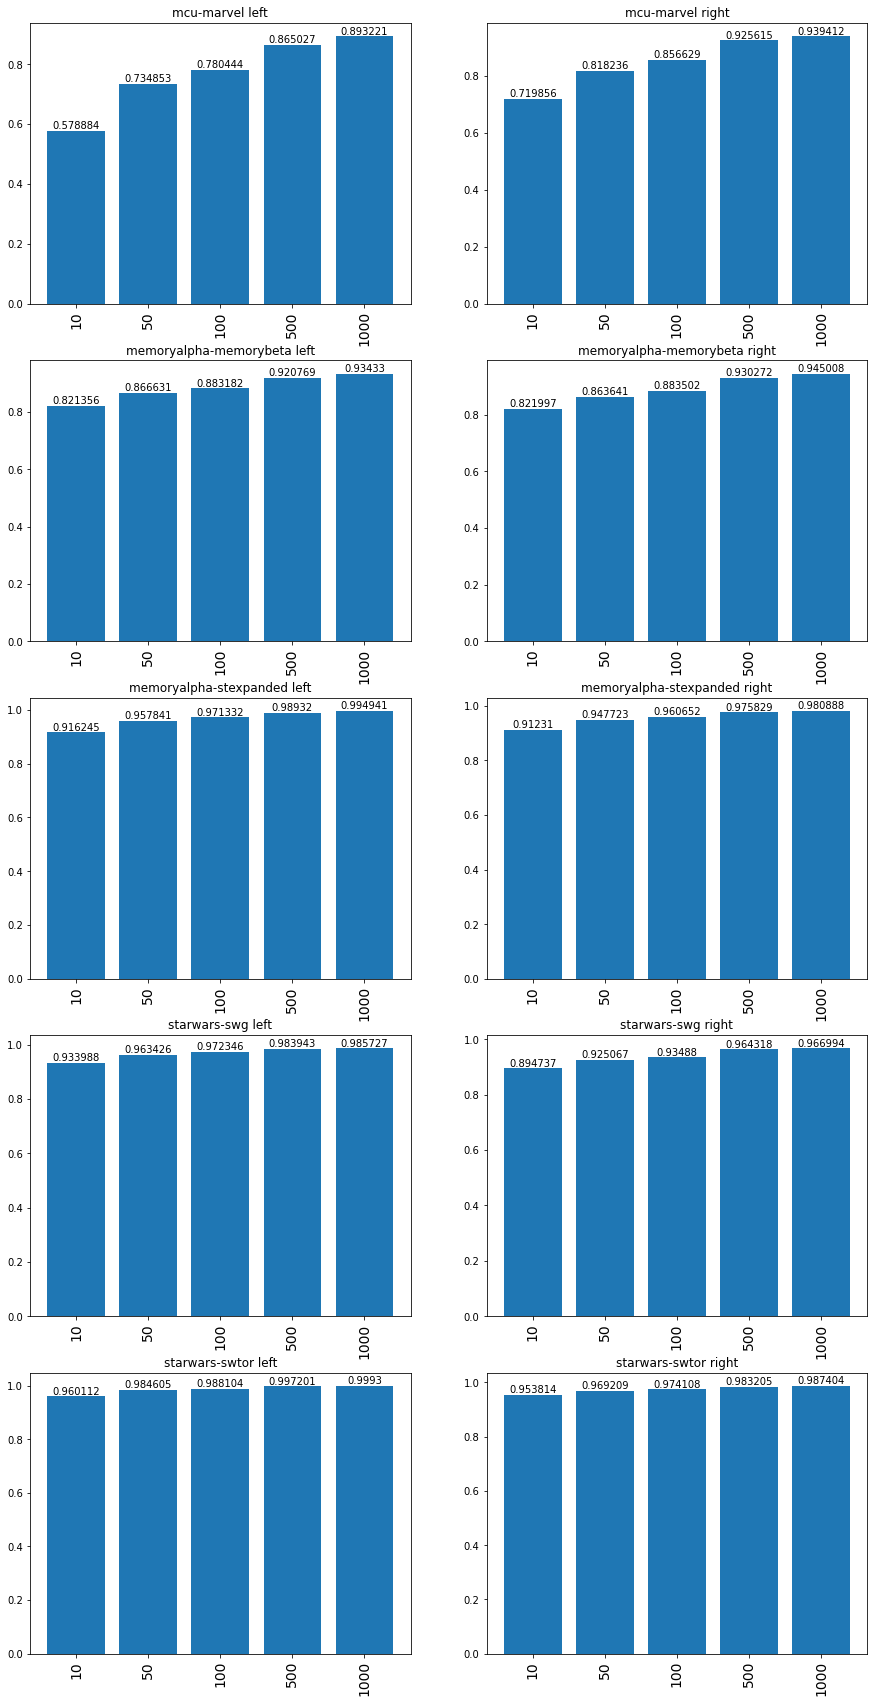

In [104]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(5, 2)
fig.set_figheight(30)
fig.set_figwidth(15)

j = 0

for i, row in grouped_data2.iterrows():
    bars = axs[j//2, j%2].bar(np.arange(len(row["topx"]))+1, row["recall"])
    tmp = axs[j//2, j%2].containers[0]
    axs[j//2, j%2].bar_label(axs[j//2, j%2].containers[0])
    axs[j//2, j%2].set_title(i[0]+" "+i[1])
    axs[j//2, j%2].set_xticklabels([0]+topXs, rotation='vertical', fontsize=14)
    j += 1

In [49]:
left_recall, left_tps, left_fns = get_left_recall(loaded_gold, gold1, g1_name2id, g2_name2id, g2_embedding, forward_top, 50)
right_recall, right_tps, right_fns = get_right_recall(loaded_gold, gold2, g1_name2id, g2_name2id, g1_embedding, backward_top, 50)

In [50]:
print(left_recall, left_tps, left_fns)
print(right_recall, right_tps, right_fns)

0.9578414839797639 1704 75
0.9477234401349073 1686 93


In [51]:
left_recall, left_tps, left_fns = get_left_recall(loaded_gold, gold1, g1_name2id, g2_name2id, g2_embedding, forward_top, 100)
right_recall, right_tps, right_fns = get_right_recall(loaded_gold, gold2, g1_name2id, g2_name2id, g1_embedding, backward_top, 100)
print(left_recall, left_tps, left_fns)
print(right_recall, right_tps, right_fns)

0.9713322091062394 1728 51
0.9606520517144463 1709 70


In [33]:
def get_recall_left(golds, keys, tops, mapper1, mapper2, topx):
    tps = list()
    fns = list()

    for goldpair in golds:
        goldkey1 = str(mapper1[goldpair[0]])
        goldkey2 = mapper2[goldpair[1]]
        if goldkey1 not in keys:
            fns.append(goldpair)
            print("no key")
            continue

        idx = keys.index(goldkey1)
        found = False
        for top_pair in tops[idx][:topx]:
            if top_pair["corpus_id"] == goldkey2:
                found = True
                tps.append(goldpair)
                break
        if found is False:
            fns.append(goldpair)
    return len(tps)/(len(tps)+len(fns)), tps, fns


In [36]:
recall, tps, fns = get_recall_left(loaded_gold, g1_golds_keys, forward_top, g1_name2id, g2_name2id, 500)

In [37]:
recall

0.01854974704890388

In [38]:
print(len(tps), len(fns))

33 1746


In [16]:
missing

[]

In [24]:
len(forward_top10)

1779

In [22]:
forward_top10[0][0]

{'corpus_id': 6851, 'score': 0.8677462935447693}

In [10]:
g1_embedding.keys()

dict_keys(['0', '2', '3', '6', '9', '11', '12', '13', '14', '16', '18', '19', '20', '21', '22', '23', '24', '26', '27', '28', '29', '33', '36', '37', '38', '39', '40', '41', '42', '43', '44', '47', '50', '51', '52', '53', '54', '55', '56', '58', '59', '62', '63', '64', '65', '66', '67', '68', '69', '73', '74', '75', '77', '79', '80', '81', '83', '84', '85', '87', '88', '89', '90', '91', '93', '95', '99', '101', '103', '107', '108', '109', '110', '111', '112', '113', '114', '115', '118', '119', '120', '122', '124', '125', '126', '127', '129', '130', '131', '132', '133', '134', '137', '139', '140', '141', '143', '144', '145', '148', '151', '152', '153', '154', '156', '157', '158', '159', '163', '166', '167', '168', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '185', '188', '189', '191', '193', '194', '195', '196', '197', '198', '199', '201', '202', '203', '204', '205', '206', '207', '209', '211', '212', '213', '215', '216', '217', '218', '219', '220', '221